# Customer Segmentation with Clustering

### What is Customer Segmentation?

Customer segmentation is grouping customers into meaningful categories based on behavior or attributes. In an unsupervised setting, you do not have labels like “premium” or “churn risk.” Instead, you let patterns in the data suggest segments.

A clustering model does not automatically create business meaning. The clustering step produces groups. Interpretation comes from what the features represent, how stable the clusters are, and whether the segments map to actions you can take.

### Objectives

- Clean and preprocess the data by handling missing values, applying transformations if needed, and scaling features so no single variable dominates the clustering.
- Apply one or more clustering algorithms (for example K-Means, hierarchical clustering, or DBSCAN) and choose model parameters using appropriate diagnostics and metrics.
- Assign each customer to a cluster and evaluate whether the resulting segments are stable and meaningfully separated.
- Profile each cluster using summary statistics and visualizations to understand how the segments differ from one another.
- Describe each segment in plain language and propose at least one concrete business action or insight that could be taken based on the segmentation.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE

import os

if os.path.isdir('assets') == False:
    os.mkdir('assets')

## Data Wrangling/EDA

In [78]:
# Plotting function after running models.
# 1x3 grid. Silhouette Plot | 2D t-SNE | 3D t-SNE

def model_plots(X, model_labels, model_string, model_arg, asset_path=False):

    num_clusters = len(np.unique(model_labels))
    min_cluster = np.min(model_labels)
    model_title = model_string.split('(')[0]
    model_arg = str(model_arg)
    plot_title = model_title + ' ' + model_arg
    
    if asset_path:
        file_name = model_title + '_' + model_arg + '.png'
        path = 'assets/' + asset_path
    
        if os.path.isdir(path) == False:
            os.mkdir(path)
    
    fig = plt.figure(figsize=(12, 4), layout='constrained')

    # This silhouette plot code adapated directly from scikit-learn/class 
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (num_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, model_labels)
    sample_silhouette_values = silhouette_samples(X, model_labels)
    y_lower = 10
    for i in range(min_cluster, num_clusters + min_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[model_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i - min_cluster) / (num_clusters - 1))
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=1,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot - "+ plot_title)
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2-D plot using t-SNE
    
    ax2 = fig.add_subplot(1, 3, 2)
    tsne_2 = TSNE(n_components=2)
    X_tsne_2 = tsne_2.fit_transform(X)
    ax2.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=model_labels, cmap='rainbow')
    plt.title('2-D t-SNE - ' + plot_title)

    #3-D plot using t-SNE
    
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    tsne_3 = TSNE(n_components=3)
    X_tsne_3 = tsne_3.fit_transform(X)
    ax3.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=model_labels, cmap='rainbow')
    ax3.set_title('3-D t-SNE - ' + plot_title)

    if asset_path:
        plt.savefig(path + '/' + file_name)
    
    plt.show()

In [39]:
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')

# Fork off stacked table for viz

stacked_df = pd.melt(df, id_vars=['Channel', 'Region'])
stacked_df.columns = ['Channel', 'Region', 'Category', 'Spending']
stacked_df['Channel'] = stacked_df['Channel'].map({1:'HoReCa', 2:'Retail'})
stacked_df['Region'] = stacked_df['Region'].map({1:'Lisbon', 2:'Oporto', 3:'Other'})
stacked_df['Category'] = stacked_df['Category'].where(stacked_df['Category'] != 'Detergents_Paper', other='Dry')
stacked_df['Category'] = stacked_df['Category'].where(stacked_df['Category'] != 'Delicassen', other='Deli')

# Create total column on main dataset

df['Total'] = df.drop(columns=['Channel', 'Region']).sum(axis=1)
df.sort_values('Total', ascending=False)

Channel  Region   Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
85         2       3   16117  46197    92780    1026             40827   
47         2       3   44466  54259    55571    7782             24171   
181        1       3  112151  29627    18148   16745              4948   
183        1       3   36847  43950    20170   36534               239   
61         2       3   35942  38369    59598    3254             26701   
..       ...     ...     ...    ...      ...     ...               ...   
131        1       3    2101    589      314     346                70   
355        1       3     190    727     2012     245               184   
98         1       3     503    112      778     895                56   
97         1       3     403    254      610     774                54   
154        1       3     622     55      137      75                 7   

     Delicassen   Total  
85         2944  199891  
47         6465  192714  
181        8550  190169  
183       47943  185683  
61         2017  165881  
..          ...     ...  
131         310    3730  
355         127    3485  
98          132    2476  
97           63    2158  
154           8     904  

[440 rows x 9 columns]

In [40]:
# Check column datatypes, missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
 8   Total             440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [41]:
# Summary stats

display(df.describe())

print('% Spending by Channel')
print('-'*24)
print(stacked_df.groupby(['Channel'])['Spending'].sum() / stacked_df['Spending'].sum() * 100)
print()
print('% Spending by Region')
print('-'*24)
print(stacked_df.groupby(['Region'])['Spending'].sum() / stacked_df['Spending'].sum() * 100)
print('% Spending by Category')
print('-'*24)
print(stacked_df.groupby(['Category'])['Spending'].sum() / stacked_df['Spending'].sum() * 100)

Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen          Total  
count    440.000000        440.000000    440.000000     440.000000  
mean    3071.931818       2881.493182   1524.870455   33226.136364  
std     4854.673333       4767.854448   2820.105937   26356.301730  
min       25.000000          3.000000      3.000000     904.000000  
25%      742.250000        256.750000    408.250000   17448.750000  
50%     1526.000000        816.500000    965.500000   27492.000000  
75%     3554.250000       3922.000000   1820.250000   41307.500000  
max    60869.000000      40827.000000  47943.000000  199891.000000

% Spending by Channel
------------------------
Channel
HoReCa    54.718486
Retail    45.281514
Name: Spending, dtype: float64

% Spending by Region
------------------------
Region
Lisbon    16.326229
Oporto    10.637081
Other     73.036691
Name: Spending, dtype: float64
% Spending by Category
------------------------
Category
Deli        4.589370
Dry         8.672369
Fresh      36.117042
Frozen      9.245528
Grocery    23.930791
Milk       17.444899
Name: Spending, dtype: float64


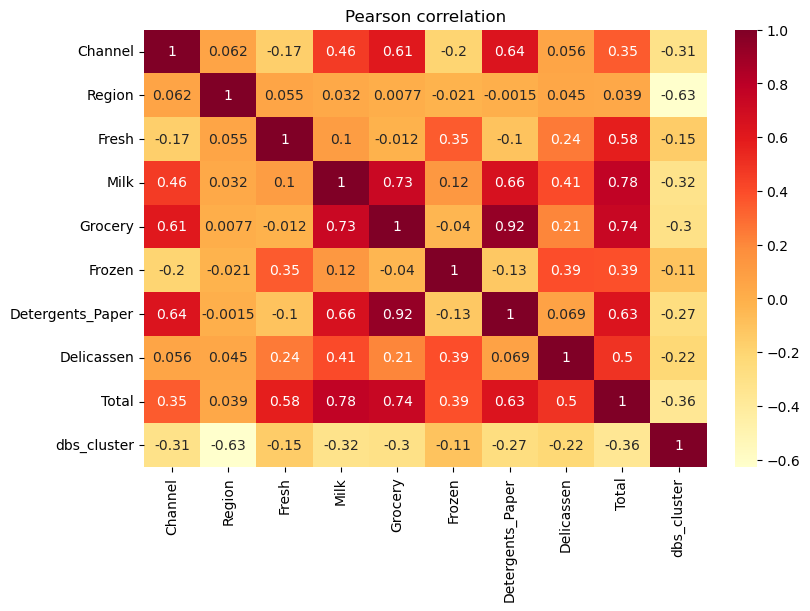

In [59]:
# Correlation plot

plt.figure(figsize=(8,6), layout='constrained')
sns.heatmap(df.corr(), annot=True, cmap='YlOrRd')
plt.title("Pearson correlation")
plt.savefig('assets/correlation.png')
plt.show()

In [ ]:
# Make spending mosaic plots from stacked df

sum_data = stacked_df.groupby(['Channel', 'Region', 'Category']).sum().reset_index()
sum_data['percent'] = round(sum_data['Spending'] / sum_data['Spending'].sum() * 100,1)

data = {}
label_map={}
for index, row in sum_data.iterrows():
    data.update({(row['Region'], row['Category'], row['Channel']): row['Spending']})
    label_map.update({(row['Region'], row['Category'], row['Channel']): (row['Category'] + '\n' + row['Channel'] + '\n' + str(row['percent']) + '%')})

labelizer=lambda x:label_map[x]

plt.rcParams["figure.figsize"] = [12, 10]
mosaic(data, labelizer=labelizer, title='Total Spending by Channel, Region, Category');
plt.savefig('assets/mosaic.png')
plt.show()


In [ ]:
# Visualization Grid

fig, axs = plt.subplots(len(df.columns), 5, figsize=(20,32), layout='constrained', gridspec_kw={'width_ratios': [0.6,1,1,1,1]})
i=0 
legend_bool = True

plt.suptitle('Category Spending', fontsize=20)

for col in df.columns:
    axs[i,0].axis('off')
    axs[i,0].text(0, 0.5, col, fontsize=16)
    sns.histplot(data=df, x=col, bins=20, kde=True, hue='Channel' , multiple='stack', legend=legend_bool, palette='Set1', ax=axs[i,1])
    sns.boxplot(data=df, x='Channel', y=col, hue='Channel', legend=legend_bool,  palette='Set1', ax=axs[i,2])
    sns.histplot(data=df, x=col, bins=20, kde=True, hue='Region' , multiple='stack', legend=legend_bool, palette='Set1', ax=axs[i,3])
    sns.boxplot(data=df, x='Region', y=col, hue='Region', legend=legend_bool,  palette='Set1', ax=axs[i,4])

    i += 1
    legend_bool = False
    
plt.show()

## Modeling - K-Means

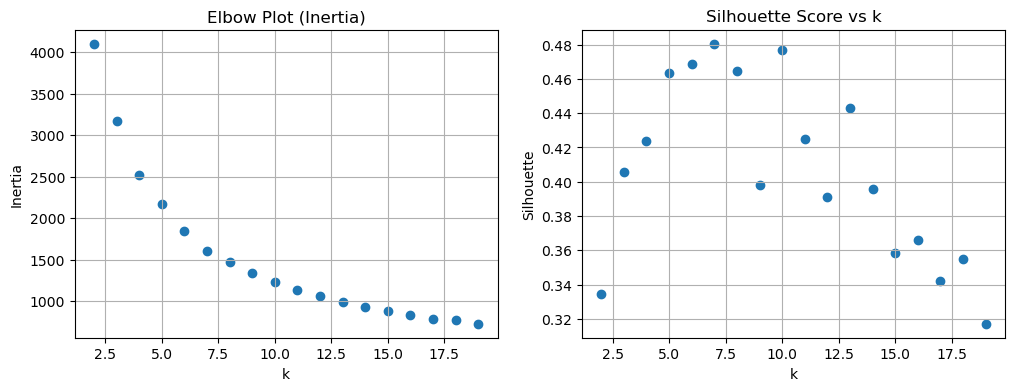

In [75]:
# Test k-Means over large range for Inertia Plot, Silhouette trends

df_dummies = pd.get_dummies(df, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)

ks = range(2, 20)
inertias = []
sils = []


for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))


plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(list(ks), inertias)
plt.title("Elbow Plot (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(list(ks), sils)
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

plt.savefig('assets/models/elbow.png')
plt.show()

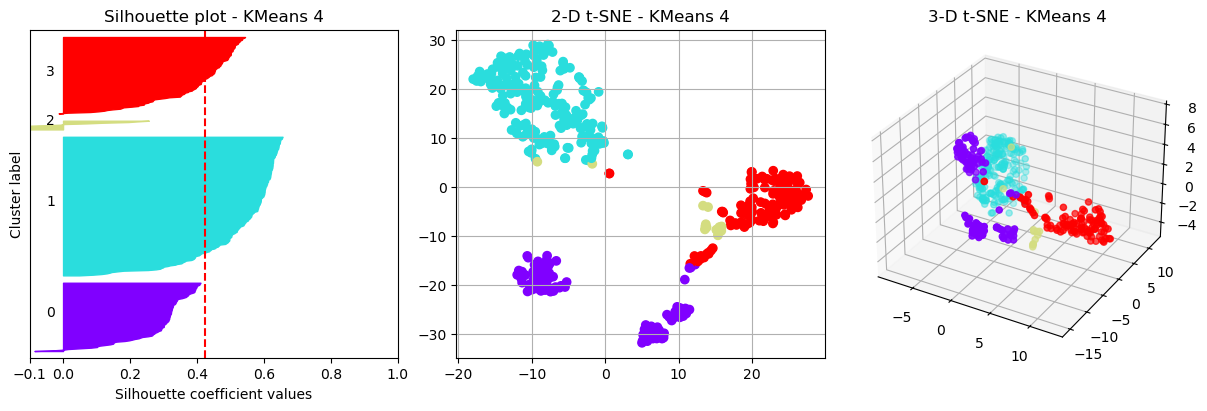

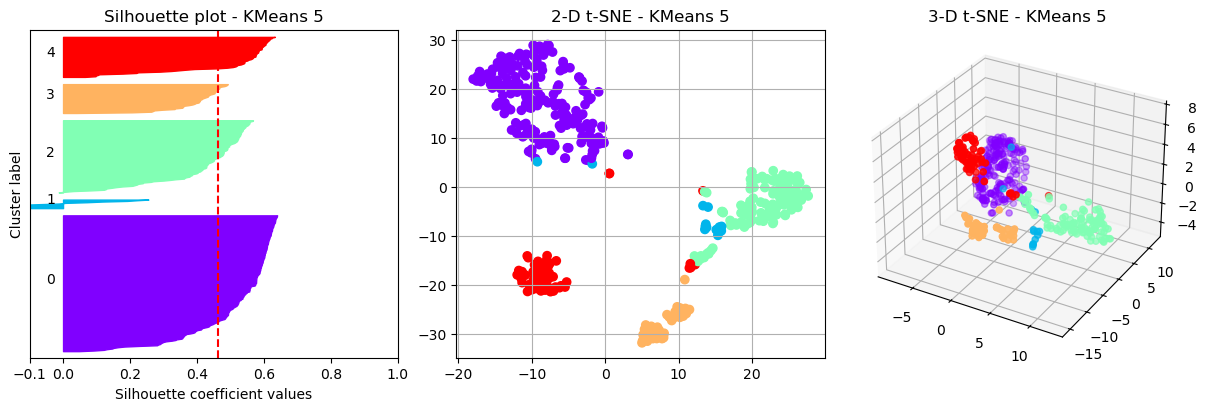

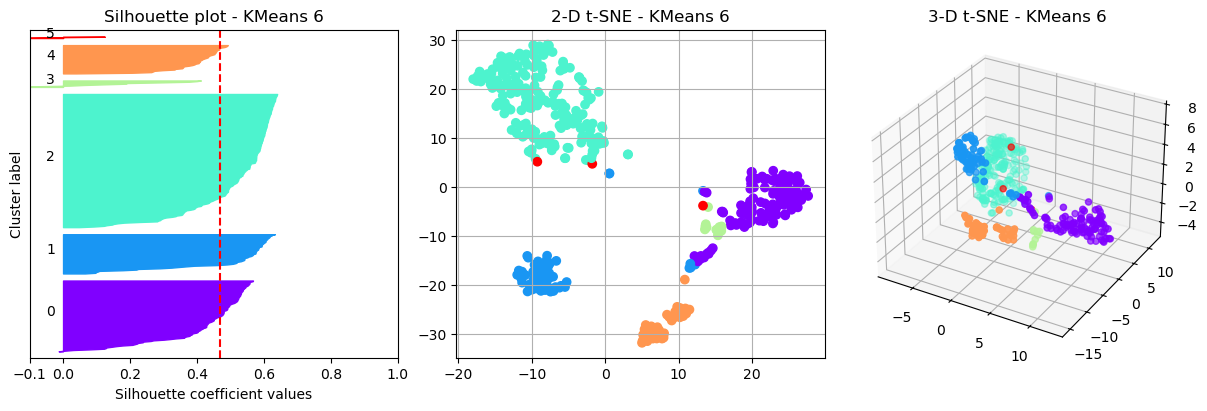

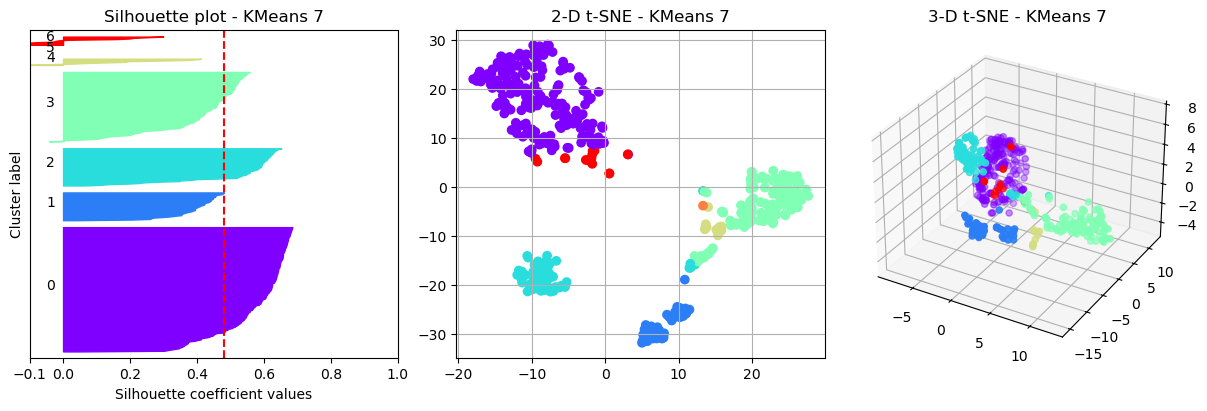

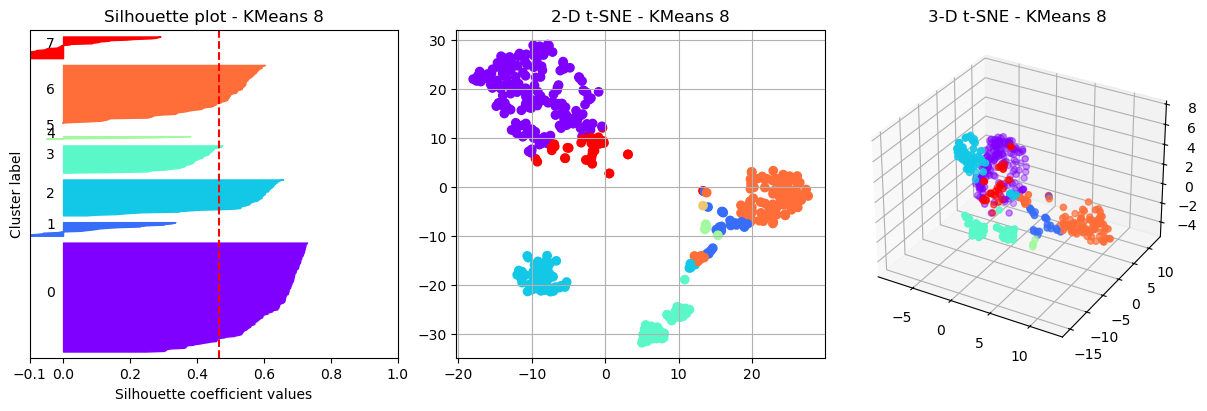

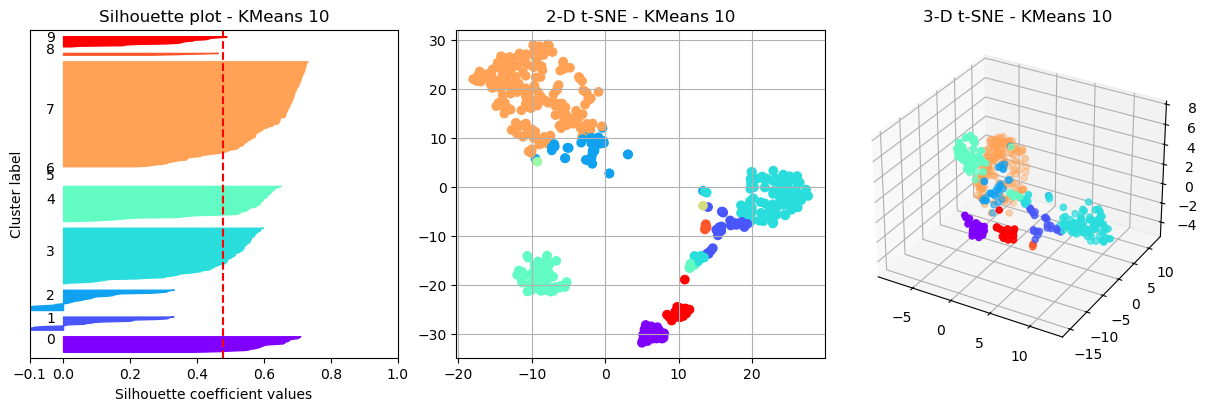

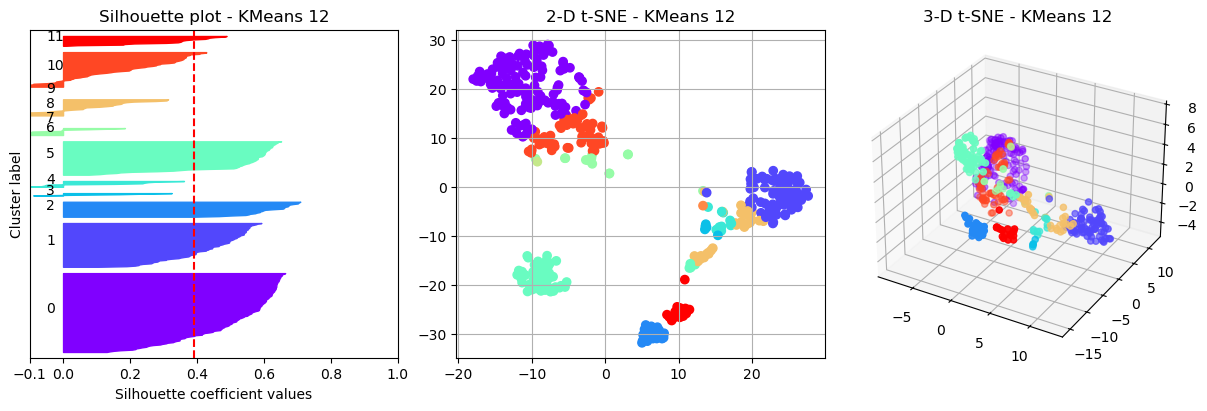

In [77]:
# Iterate k-Means k parameter over target range, generate silhouette and 2D/3D plots for each k

df_dummies = pd.get_dummies(df, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)

for k in [4,5,6,7,8,10,12]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = km.fit_predict(X_scaled)

    model_plots(X_scaled, km_labels, str(km), k, 'models')


In [63]:
# Generate descriptive statistics for clusters generated by best k-Means model

k=6
km = KMeans(n_clusters=k, random_state=42, n_init=10)
km_labels = km.fit_predict(X_scaled)
df['km_cluster'] = km_labels

summ_df = df.groupby('km_cluster').agg({
    'Total':['count', 'sum', 'mean'],
    'Fresh':['sum', 'mean'],
    'Grocery':['sum', 'mean'],
    'Milk':['sum', 'mean'],
    'Frozen':['sum', 'mean'],
    'Detergents_Paper':['sum', 'mean'],
    'Delicassen':['sum', 'mean']  
})
summ_df[('Channel','mode')] = df[['km_cluster', 'Channel']].groupby('km_cluster').agg(pd.Series.mode)
summ_df[('Region','mode')] = df[['km_cluster', 'Region']].groupby('km_cluster').agg(pd.Series.mode)

summ_df[('Channel','mode')] = summ_df[('Channel','mode')].map({1:'HoReCa', 2:'Retail'})
summ_df[('Region','mode')] = summ_df[('Region','mode')].map({1:'Lisbon', 2:'Oporto', 3:'Other'})

display_cols =     [(         'Channel',  'mode'),
                    (          'Region',  'mode'),
                    (           'Total', 'count'),
                    (           'Total',   'sum'),
                    (           'Total',  'mean'),
                    (           'Fresh',   'sum'),
                    (           'Fresh',  'mean'),
                    (         'Grocery',   'sum'),
                    (         'Grocery',  'mean'),
                    (            'Milk',   'sum'),
                    (            'Milk',  'mean'),
                    (          'Frozen',   'sum'),
                    (          'Frozen',  'mean'),
                    ('Detergents_Paper',   'sum'),
                    ('Detergents_Paper',  'mean'),
                    (      'Delicassen',   'sum'),
                    (      'Delicassen',  'mean')]

markdown_cols =    [(         'Channel',  'mode'),
                    (          'Region',  'mode'),
                    (           'Total', 'count'),
                    (           'Total',   'sum'),
                    (           'Total',  'mean'),
                    (           'Fresh',   'sum'),
                    (           'Fresh',  'mean'),
                    (         'Grocery',   'sum'),
                    (         'Grocery',  'mean'),
                    (            'Milk',   'sum'),
                    (            'Milk',  'mean')]

display(round(summ_df[display_cols].sort_values([('Total','sum')], ascending=False),0))
print(round(summ_df[markdown_cols].sort_values([('Total','sum')], ascending=False),0).to_markdown())

Channel  Region Total                       Fresh           \
              mode    mode count      sum      mean      sum     mean   
km_cluster                                                              
0           HoReCa   Other   208  5309247   25525.0  2768588  13311.0   
4           Retail   Other   110  4433629   40306.0   921949   8381.0   
5           HoReCa  Lisbon    63  1654317   26259.0   798418  12673.0   
3           HoReCa  Oporto    45  1303920   28976.0   423439   9410.0   
1           Retail   Other    10  1300829  130083.0   159649  15965.0   
2           HoReCa   Other     4   617558  154390.0   208088  52022.0   

            Grocery             Milk           Frozen           \
                sum     mean     sum     mean     sum     mean   
km_cluster                                                       
0            766383   3685.0  640318   3078.0  714692   3436.0   
4           1556774  14152.0  971274   8830.0  154828   1408.0   
5            263723   4186.0  247516   3929.0  203150   3225.0   
3            352350   7830.0  217380   4831.0  129132   2870.0   
1            485369  48537.0  347085  34708.0   30546   3055.0   
2             73963  18491.0  126784  31696.0  119302  29826.0   

           Detergents_Paper          Delicassen           
                        sum     mean        sum     mean  
km_cluster                                                
0                    160521    772.0     258745   1244.0  
4                    648143   5892.0     180661   1642.0  
5                     65708   1043.0      75802   1203.0  
3                    133937   2976.0      47682   1060.0  
1                    248752  24875.0      29428   2943.0  
2                     10796   2699.0      78625  19656.0

|   km_cluster | ('Channel', 'mode')   | ('Region', 'mode')   |   ('Total', 'count') |   ('Total', 'sum') |   ('Total', 'mean') |   ('Fresh', 'sum') |   ('Fresh', 'mean') |   ('Grocery', 'sum') |   ('Grocery', 'mean') |   ('Milk', 'sum') |   ('Milk', 'mean') |
|-------------:|:----------------------|:---------------------|---------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|------------------:|-------------------:|
|            0 | HoReCa                | Other                |                  208 |            5309247 |               25525 |            2768588 |               13311 |               766383 |                  3685 |            640318 |               3078 |
|            4 | Retail                | Other                |                  110 |            4433629 |               40306 |             921949 |                8381 |              1556774 |                 14152

## Modeling - DBSCAN

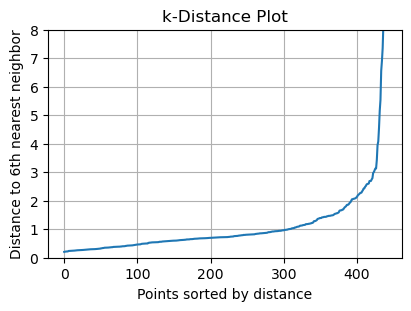

In [74]:
# k-distance plot in preparation for DBSCAN

nn = NearestNeighbors(n_neighbors=6)
nn_results = nn.fit(X_scaled)
distances, indices = nn_results.kneighbors(X_scaled)

plt.figure(figsize=(4,3), layout='constrained')
plt.plot(np.sort(distances[:, -1]))
plt.title("k-Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to 6th nearest neighbor")
ax = plt.gca()
ax.set_ylim([0, 8])
plt.grid(True)
plt.savefig('assets/models/nn_distance.png')
plt.show()

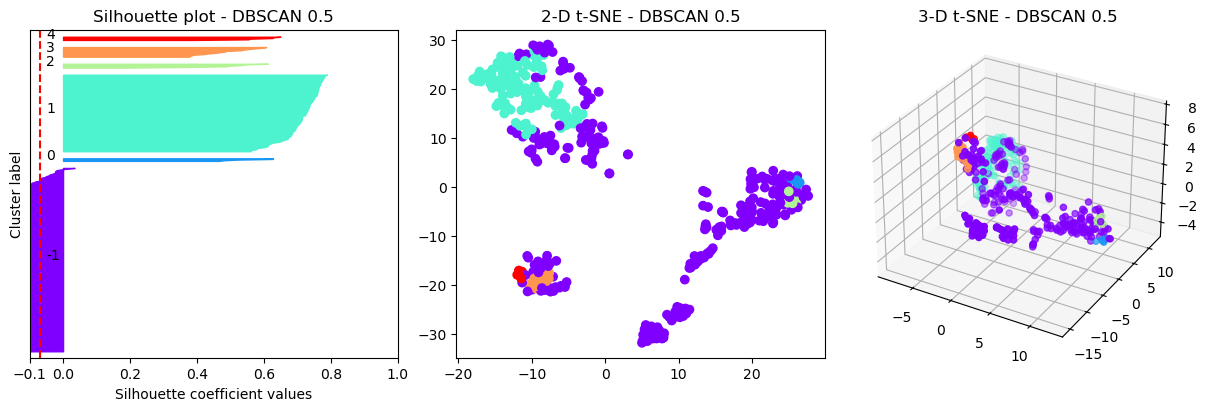

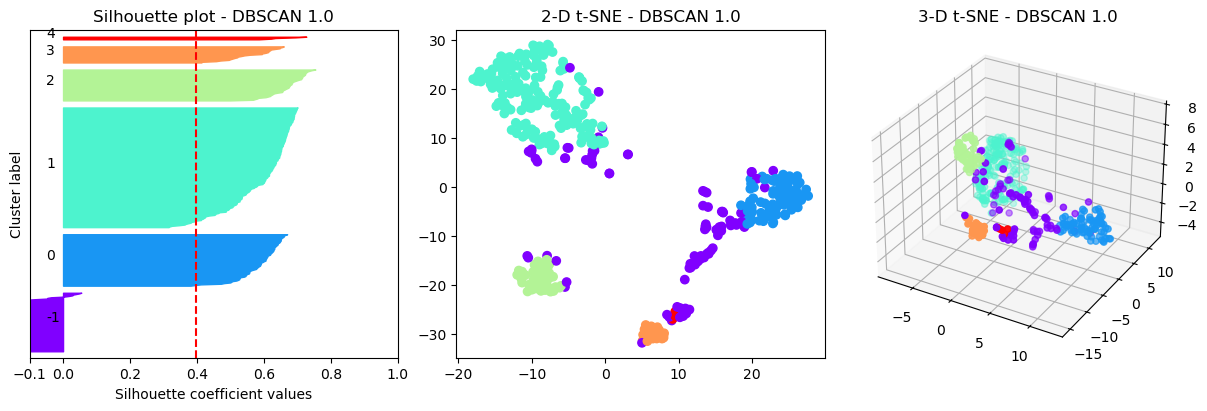

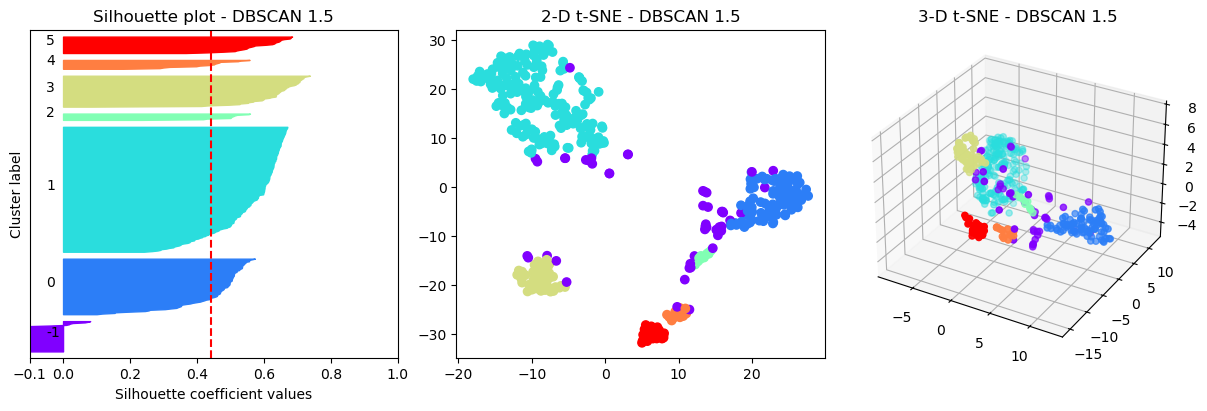

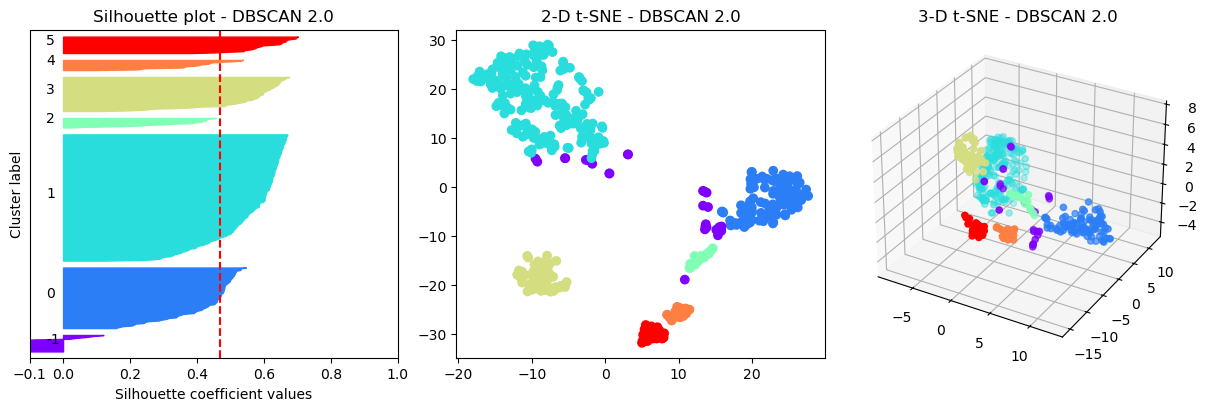

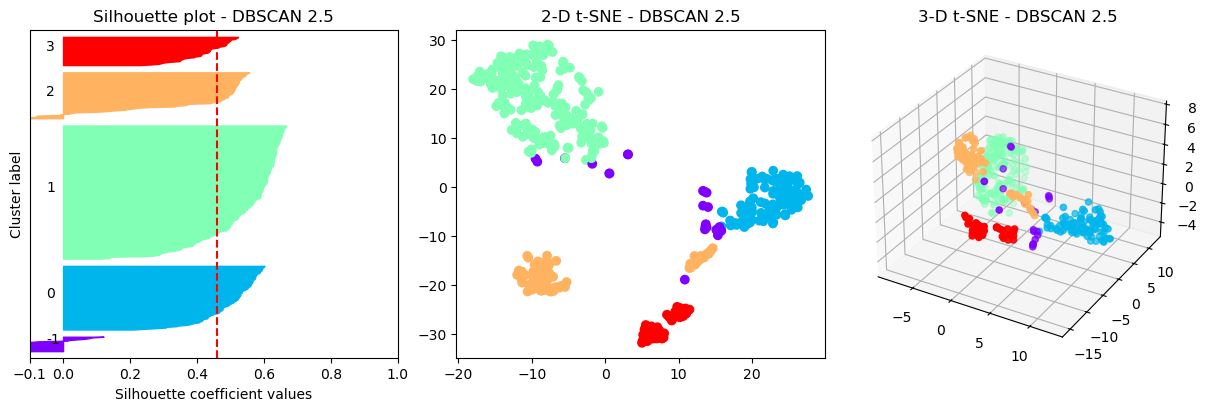

In [80]:
# Iterate DBSCAN epsilon parameter over target range, generate silhouette and 2D/3D plots for each e

df_dummies = pd.get_dummies(df, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)

for e in [0.5, 1.0, 1.5, 2.0, 2.5]:
    dbscan = DBSCAN(eps=e)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    model_plots(X_scaled, dbscan_labels, str(dbscan), e, 'models')

In [83]:
# Generate descriptive statistics for clusters generated by best DBSCAN model

e=2
dbscan = DBSCAN(eps=e)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['dbs_cluster'] = dbscan_labels

summ_df = df.groupby('dbs_cluster').agg({
    'Total':['count', 'sum', 'mean'],
    'Fresh':['sum', 'mean'],
    'Grocery':['sum', 'mean'],
    'Milk':['sum', 'mean'],
    'Frozen':['sum', 'mean'],
    'Detergents_Paper':['sum', 'mean'],
    'Delicassen':['sum', 'mean']  
})
summ_df[('Channel','mode')] = df[['dbs_cluster', 'Channel']].groupby('dbs_cluster').agg(pd.Series.mode)
summ_df[('Region','mode')] = df[['dbs_cluster', 'Region']].groupby('dbs_cluster').agg(pd.Series.mode)

summ_df[('Channel','mode')] = summ_df[('Channel','mode')].map({1:'HoReCa', 2:'Retail'})
summ_df[('Region','mode')] = summ_df[('Region','mode')].map({1:'Lisbon', 2:'Oporto', 3:'Other'})

display(round(summ_df[display_cols].sort_values([('Total','sum')], ascending=False),0))
print(round(summ_df[markdown_cols].sort_values([('Total','sum')], ascending=False),0).to_markdown())

Channel  Region Total                       Fresh           \
               mode    mode count      sum      mean      sum     mean   
dbs_cluster                                                              
 1           HoReCa   Other   201  4773079   23747.0  2502684  12451.0   
 0           Retail   Other    97  3844624   39635.0   873104   9001.0   
-1           HoReCa   Other    27  2807083  103966.0   801547  29687.0   
 3           HoReCa  Lisbon    55  1278663   23248.0   620833  11288.0   
 4           Retail  Oporto    17   679776   39987.0   113118   6654.0   
 2           Retail  Lisbon    16   648002   40500.0    75347   4709.0   
 5           HoReCa  Oporto    27   588273   21788.0   293498  10870.0   

             Grocery             Milk           Frozen           \
                 sum     mean     sum     mean     sum     mean   
dbs_cluster                                                       
 1            697698   3471.0  595222   2961.0  605215   3011.0   
 0           1308340  13488.0  825937   8515.0  134799   1390.0   
-1            678809  25141.0  586287  21714.0  299173  11080.0   
 3            204893   3725.0  183806   3342.0  159858   2907.0   
 4            240159  14127.0  168717   9925.0   17581   1034.0   
 2            259215  16201.0  142653   8916.0   35032   2190.0   
 5            109448   4054.0   47735   1768.0   99992   3703.0   

            Detergents_Paper          Delicassen          
                         sum     mean        sum    mean  
dbs_cluster                                               
 1                    151819    755.0     220441  1097.0  
 0                    547437   5644.0     155007  1598.0  
-1                    271675  10062.0     169592  6281.0  
 3                     53270    969.0      56003  1018.0  
 4                    121361   7139.0      18840  1108.0  
 2                    110051   6878.0      25704  1606.0  
 5                     12244    453.0      25356   939.0

|   dbs_cluster | ('Channel', 'mode')   | ('Region', 'mode')   |   ('Total', 'count') |   ('Total', 'sum') |   ('Total', 'mean') |   ('Fresh', 'sum') |   ('Fresh', 'mean') |   ('Grocery', 'sum') |   ('Grocery', 'mean') |   ('Milk', 'sum') |   ('Milk', 'mean') |
|--------------:|:----------------------|:---------------------|---------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|------------------:|-------------------:|
|             1 | HoReCa                | Other                |                  201 |            4773079 |               23747 |            2502684 |               12451 |               697698 |                  3471 |            595222 |               2961 |
|             0 | Retail                | Other                |                   97 |            3844624 |               39635 |             873104 |                9001 |              1308340 |                 1

## Model - Hierarchial clustering

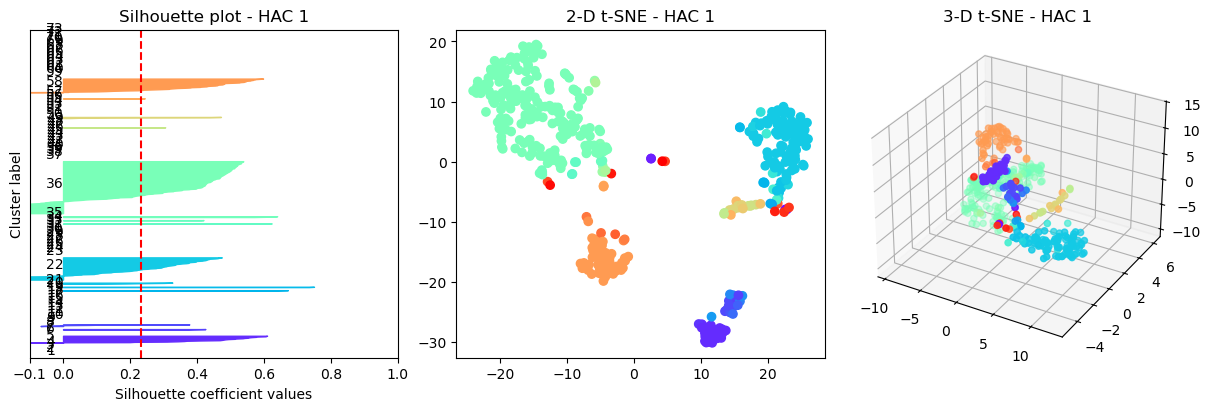

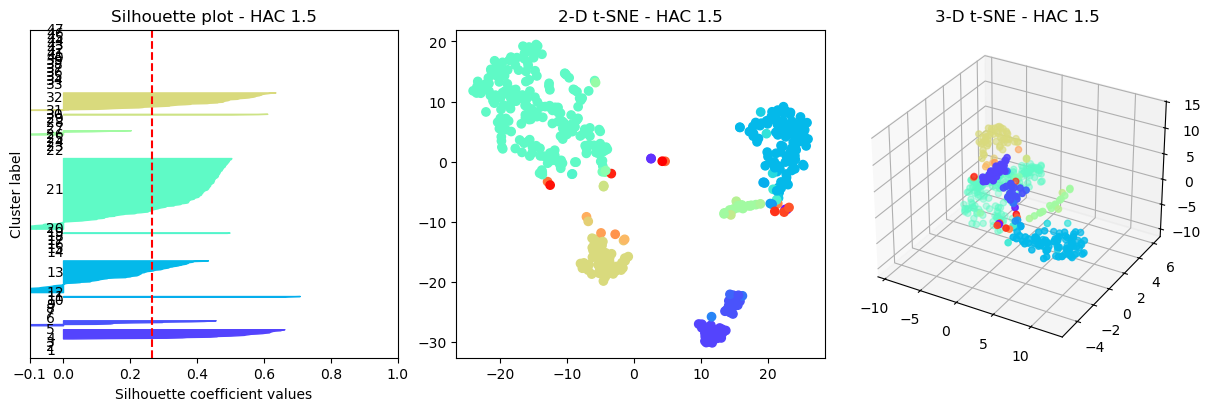

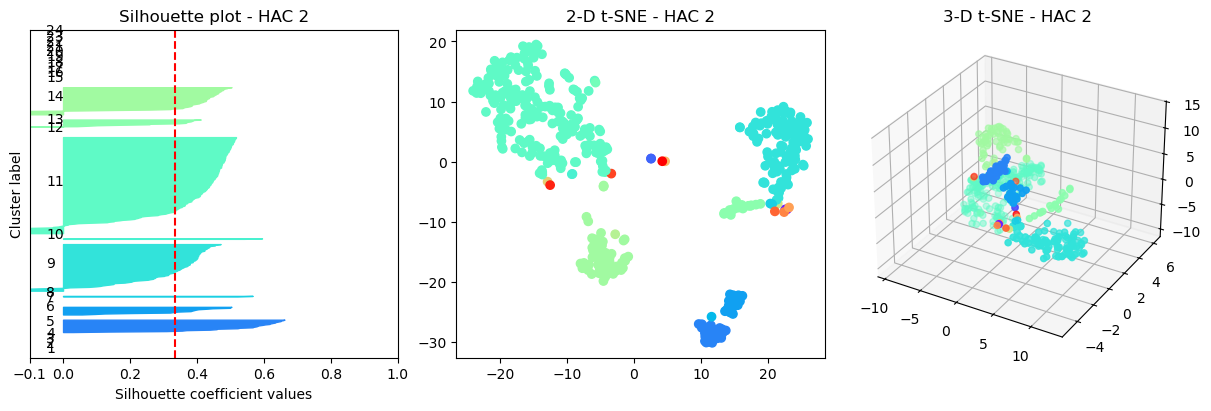

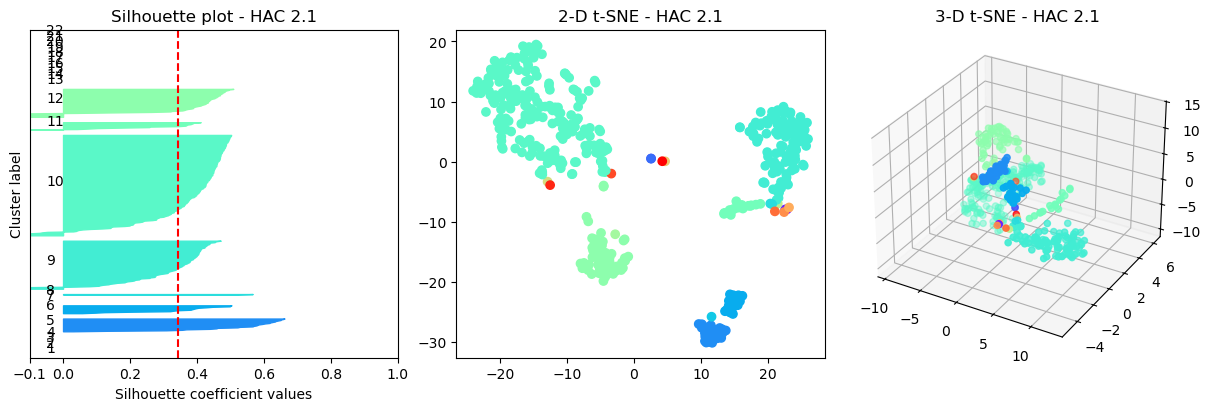

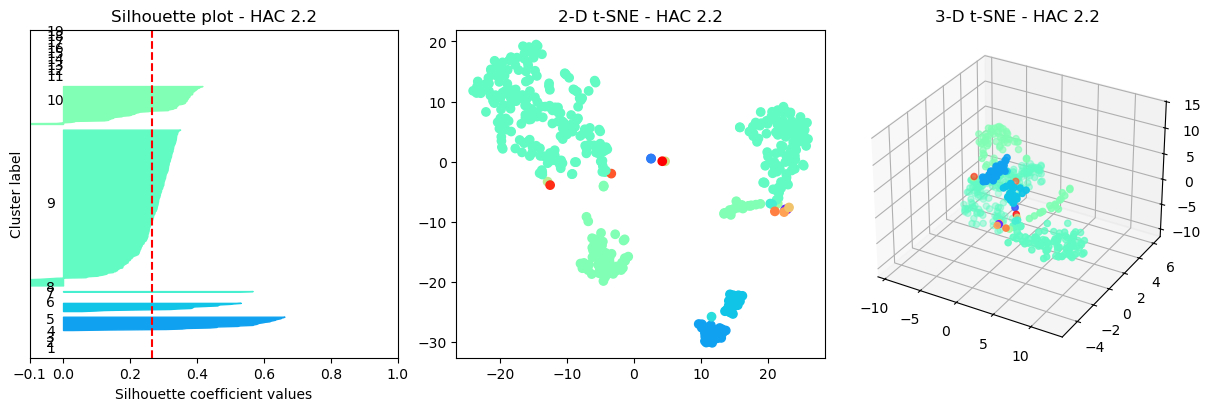

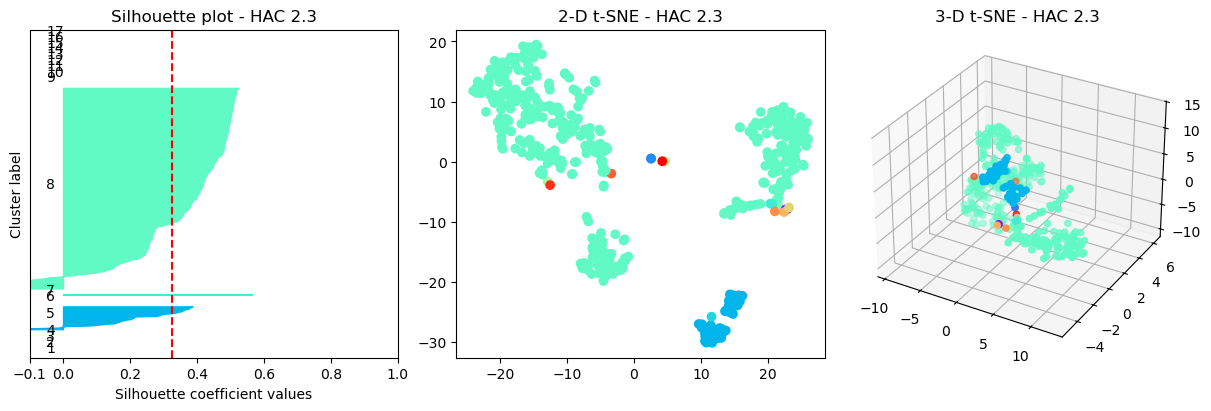

In [35]:
# Iterate HAC t parameter over target range, generate silhouette and 2D/3D plots for each t

df_dummies = pd.get_dummies(df, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)

for t in [1,1.5,2,2.1,2.2,2.3]:
    hac = linkage(X_scaled)
    hac_label = fcluster(hac, t=t, criterion='distance')

    model_plots(X_scaled, hac_label, 'HAC', t, 'models')

In [85]:
# Generate descriptive statistics for clusters generated by best HAC model

t=2.2
hac = linkage(X_scaled)
hac_label = fcluster(hac, t=t, criterion='distance')
df['hac_cluster'] = hac_label

summ_df = df.groupby('hac_cluster').agg({
    'Total':['count', 'sum', 'mean'],
    'Fresh':['sum', 'mean'],
    'Grocery':['sum', 'mean'],
    'Milk':['sum', 'mean'],
    'Frozen':['sum', 'mean'],
    'Detergents_Paper':['sum', 'mean'],
    'Delicassen':['sum', 'mean']  
})
summ_df[('Channel','mode')] = df[['hac_cluster', 'Channel']].groupby('hac_cluster').agg(pd.Series.mode)
summ_df[('Region','mode')] = df[['hac_cluster', 'Region']].groupby('hac_cluster').agg(pd.Series.mode)

summ_df[('Channel','mode')] = summ_df[('Channel','mode')].map({1:'HoReCa', 2:'Retail'})
summ_df[('Region','mode')] = summ_df[('Region','mode')].map({1:'Lisbon', 2:'Oporto', 3:'Other'})

display(round(summ_df[display_cols].sort_values([('Total','sum')], ascending=False),0).head(10))
#print(round(summ_df[markdown_cols].sort_values([('Total','sum')], ascending=False),0).to_markdown())

Channel  Region Total                       Fresh           \
               mode    mode count      sum      mean      sum     mean   
hac_cluster                                                              
9            HoReCa   Other   201  4773079   23747.0  2502684  12451.0   
14           Retail   Other    99  4023148   40638.0   886400   8954.0   
12           HoReCa  Lisbon    55  1278663   23248.0   620833  11288.0   
6            Retail  Oporto    17   679776   39987.0   113118   6654.0   
11           Retail  Lisbon    16   648002   40500.0    75347   4709.0   
5            HoReCa  Oporto    27   588273   21788.0   293498  10870.0   
13           Retail  Lisbon     2   200469  100234.0    18253   9126.0   
23           Retail   Other     1   199891  199891.0    16117  16117.0   
8            HoReCa   Other     2   195544   97772.0   132319  66160.0   
1            Retail   Other     1   192714  192714.0    44466  44466.0   

             Grocery             Milk           Frozen           \
                 sum     mean     sum     mean     sum     mean   
hac_cluster                                                       
9             697698   3471.0  595222   2961.0  605215   3011.0   
14           1367240  13811.0  883301   8922.0  140647   1421.0   
12            204893   3725.0  183806   3342.0  159858   2907.0   
6             240159  14127.0  168717   9925.0   17581   1034.0   
11            259215  16201.0  142653   8916.0   35032   2190.0   
5             109448   4054.0   47735   1768.0   99992   3703.0   
13             73280  36640.0   51459  25730.0   11482   5741.0   
23             92780  92780.0   46197  46197.0    1026   1026.0   
8              16008   8004.0    6977   3488.0   34566  17283.0   
1              55571  55571.0   54259  54259.0    7782   7782.0   

            Detergents_Paper          Delicassen          
                         sum     mean        sum    mean  
hac_cluster                                               
9                     151819    755.0     220441  1097.0  
14                    584083   5900.0     161477  1631.0  
12                     53270    969.0      56003  1018.0  
6                     121361   7139.0      18840  1108.0  
11                    110051   6878.0      25704  1606.0  
5                      12244    453.0      25356   939.0  
13                     38004  19002.0       7991  3996.0  
23                     40827  40827.0       2944  2944.0  
8                       2258   1129.0       3416  1708.0  
1                      24171  24171.0       6465  6465.0

In [ ]:
# Descriptive statistics at high percentiles to determine winsorize cut-off

df.describe(percentiles=[0.90, 0.95, 0.99, 0.995])

In [87]:
# Winsorize data

win_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'Total']
df_win = df.copy()
for col in win_columns:
    limit = df_win[col].quantile(0.95)
    df_win[col] = df[col].where(df[col] < limit, other=limit)

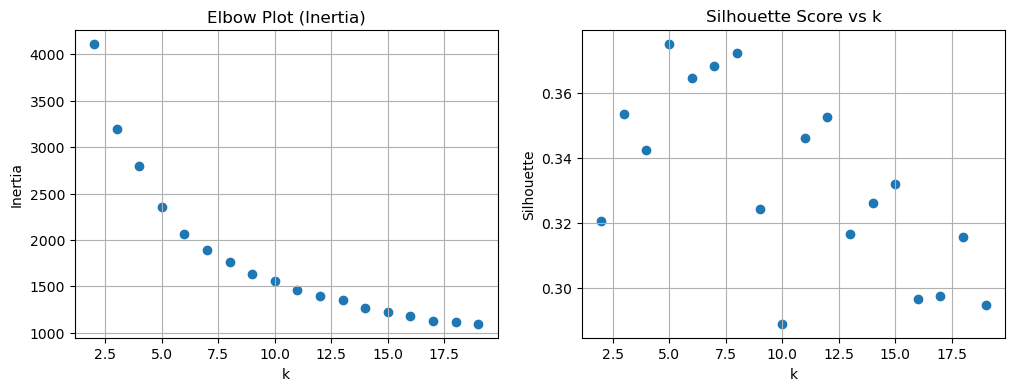

In [88]:
# Test k-Means over large range for Inertia Plot, Silhouette trends

df_win_dummies = pd.get_dummies(df_win, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_win_dummies)

ks = range(2, 20)
inertias = []
sils = []


for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))


plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(list(ks), inertias)
plt.title("Elbow Plot (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(list(ks), sils)
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

plt.savefig('assets/win_models/elbow.png')
plt.show()

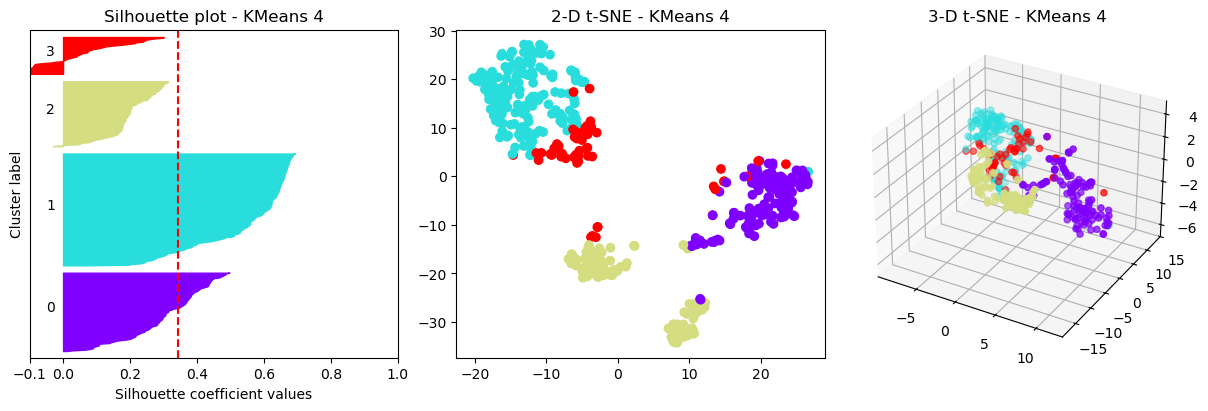

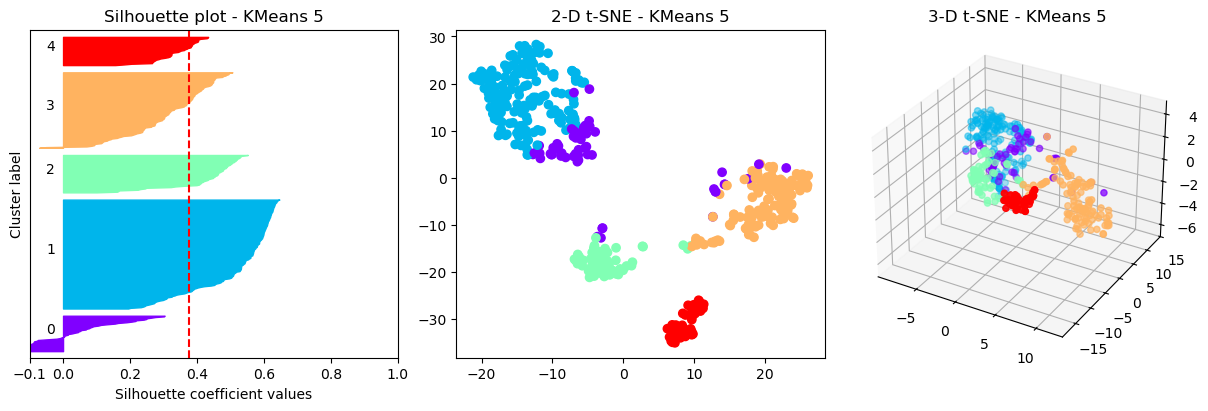

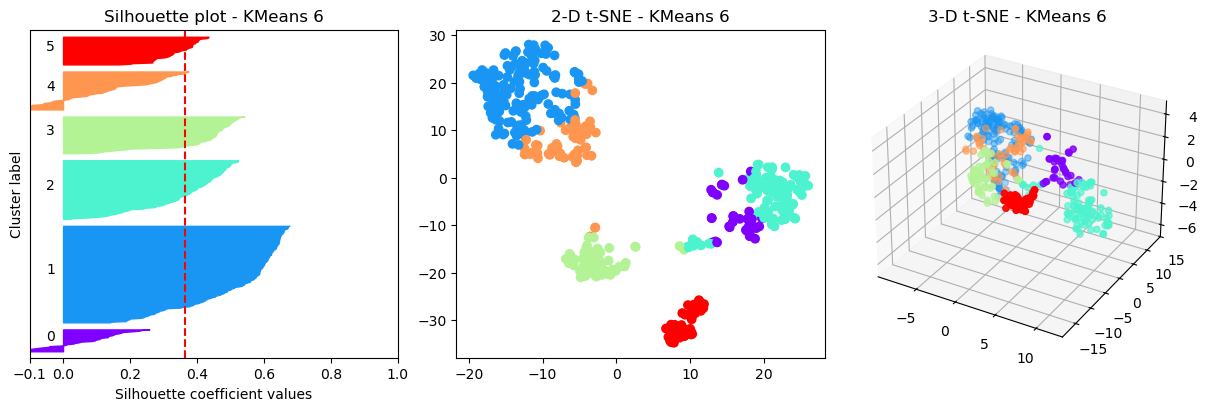

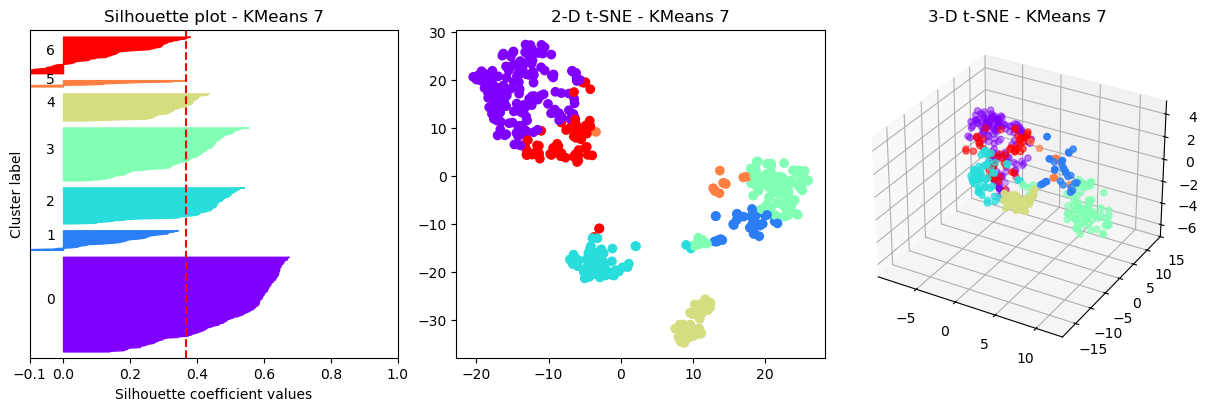

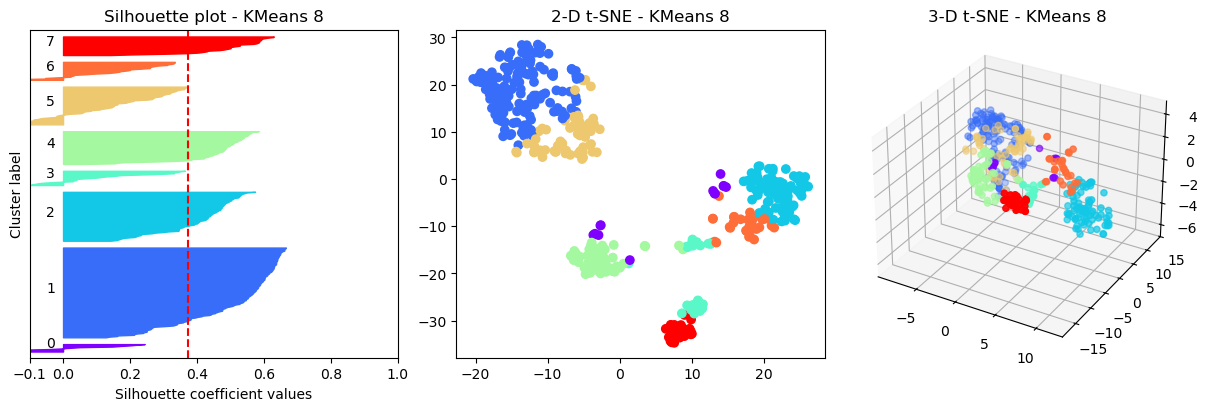

In [ ]:
# Iterate k parameter over target range, generate silhouette and 2D/3D plots for each k

df_win_dummies = pd.get_dummies(df_win, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_win_dummies)

for k in range(4,10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = km.fit_predict(X_scaled)

    model_plots(X_scaled, km_labels, str(km), k, 'win_models')

In [94]:
# Generate descriptive statistics for clusters generated by best k-Means model

k=6
km = KMeans(n_clusters=k, random_state=42, n_init=10)
km_labels = km.fit_predict(X_scaled)
df_win['km_cluster'] = km_labels

summ_df = df_win.groupby('km_cluster').agg({
    'Total':['count', 'sum', 'mean'],
    'Fresh':['sum', 'mean'],
    'Grocery':['sum', 'mean'],
    'Milk':['sum', 'mean'],
    'Frozen':['sum', 'mean'],
    'Detergents_Paper':['sum', 'mean'],
    'Delicassen':['sum', 'mean']  
})
summ_df[('Channel','mode')] = df_win[['km_cluster', 'Channel']].groupby('km_cluster').agg(pd.Series.mode)
summ_df[('Region','mode')] = df_win[['km_cluster', 'Region']].groupby('km_cluster').agg(pd.Series.mode)

summ_df[('Channel','mode')] = summ_df[('Channel','mode')].map({1:'HoReCa', 2:'Retail'})
summ_df[('Region','mode')] = summ_df[('Region','mode')].map({1:'Lisbon', 2:'Oporto', 3:'Other'})

display(round(summ_df[display_cols].sort_values([('Total','sum')], ascending=False),0))
print(round(summ_df[markdown_cols].sort_values([('Total','sum')], ascending=False),0).to_markdown())

Channel  Region Total                          Fresh           \
              mode    mode count        sum     mean        sum     mean   
km_cluster                                                                 
2           Retail   Other    92  3285833.0  35716.0   760217.0   8263.0   
4           HoReCa   Other    60  2840376.0  47340.0  1535758.0  25596.0   
1           HoReCa   Other   151  2590417.0  17155.0  1173656.0   7773.0   
0           Retail   Other    35  2290744.0  65450.0   487632.0  13932.0   
3           HoReCa  Lisbon    58  1329558.0  22923.0   616720.0  10633.0   
5           HoReCa  Oporto    44  1268049.0  28819.0   406616.0   9241.0   

              Grocery               Milk             Frozen          \
                  sum     mean       sum     mean       sum    mean   
km_cluster                                                            
2           1106254.0  12024.0  679817.0   7389.0  131119.0  1425.0   
4            290937.0   4849.0  265352.0   4423.0  369151.0  6153.0   
1            489803.0   3244.0  389876.0   2582.0  288423.0  1910.0   
0            739266.0  21122.0  517157.0  14776.0  114128.0  3261.0   
3            226177.0   3900.0  194642.0   3356.0  158294.0  2729.0   
5            346062.0   7865.0  204413.0   4646.0  109264.0  2483.0   

           Detergents_Paper         Delicassen          
                        sum    mean        sum    mean  
km_cluster                                              
2                  456687.0  4964.0   126365.0  1374.0  
4                   48526.0   809.0   110185.0  1836.0  
1                  114455.0   758.0   133209.0   882.0  
0                  309533.0  8844.0    99156.0  2833.0  
3                   62134.0  1071.0    58297.0  1005.0  
5                  128163.0  2913.0    44196.0  1004.0

|   km_cluster | ('Channel', 'mode')   | ('Region', 'mode')   |   ('Total', 'count') |   ('Total', 'sum') |   ('Total', 'mean') |   ('Fresh', 'sum') |   ('Fresh', 'mean') |   ('Grocery', 'sum') |   ('Grocery', 'mean') |   ('Milk', 'sum') |   ('Milk', 'mean') |
|-------------:|:----------------------|:---------------------|---------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|------------------:|-------------------:|
|            2 | Retail                | Other                |                   92 |        3.28583e+06 |               35716 |   760217           |                8263 |          1.10625e+06 |                 12024 |            679817 |               7389 |
|            4 | HoReCa                | Other                |                   60 |        2.84038e+06 |               47340 |        1.53576e+06 |               25596 |     290937           |                  4849

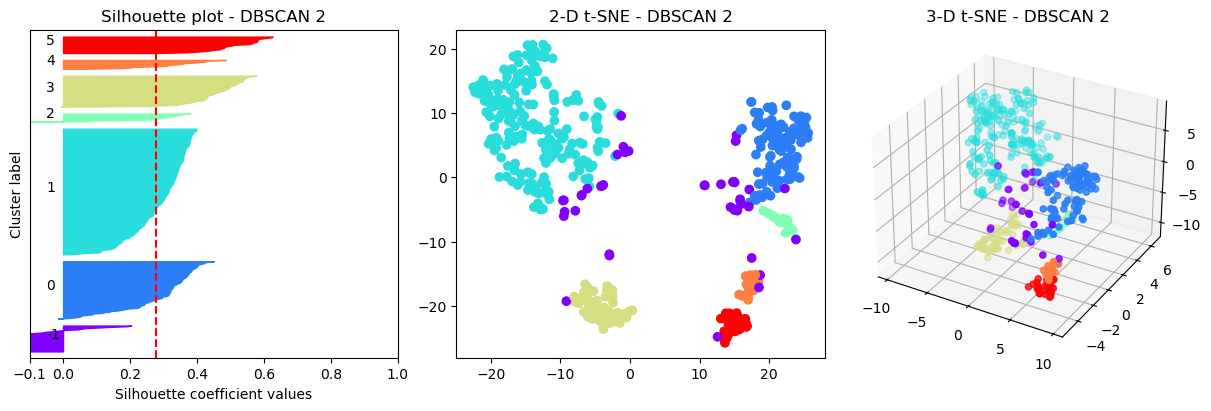

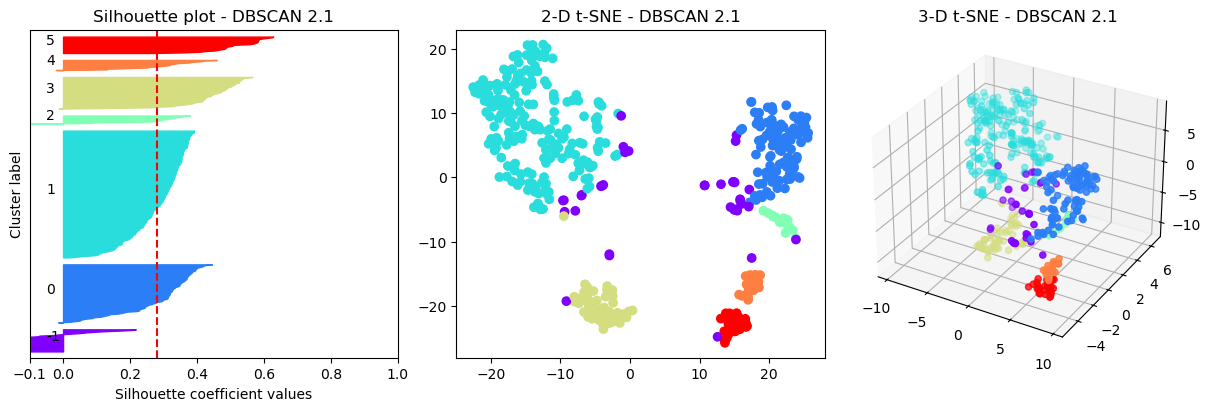

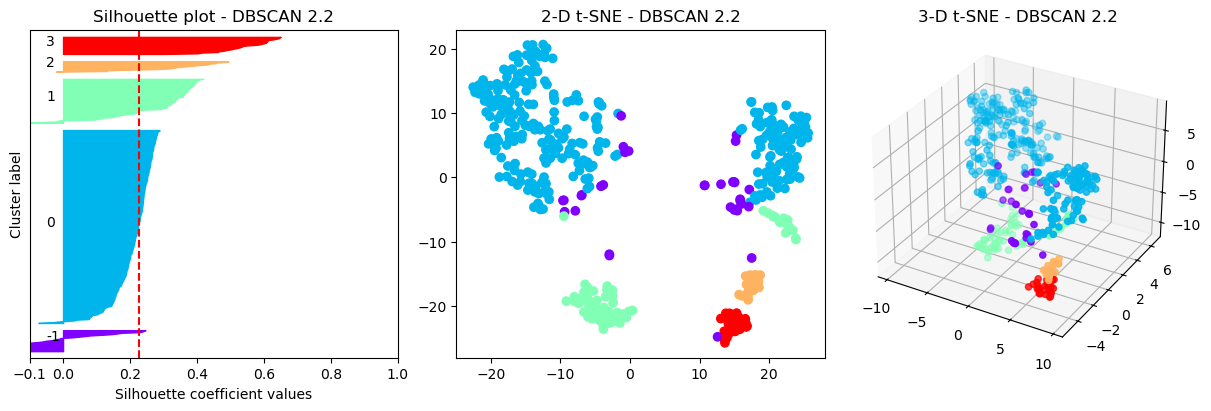

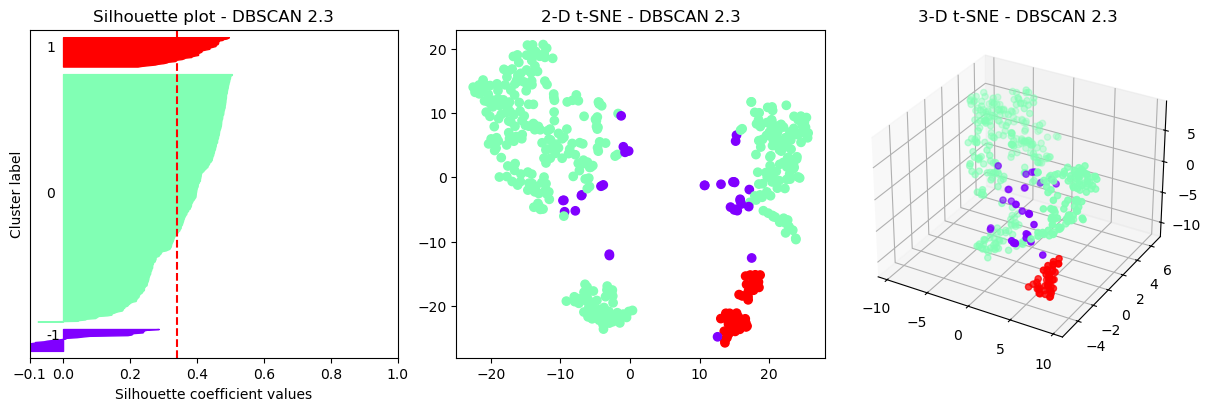

In [79]:
# Iterate DBSCAN epsilon parameter over target range, generate silhouette and 2D/3D plots for each e

df_win_dummies = pd.get_dummies(df_win, columns=['Channel', 'Region'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_win_dummies)

for e in [2, 2.1, 2.2, 2.3]:
    dbscan = DBSCAN(eps=e)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    model_plots(X_scaled, dbscan_labels, str(dbscan), e, 'win_models')

In [ ]:
# Generate descriptive statistics for clusters generated by best DBSCAN model

e=2.2
dbscan = DBSCAN(eps=e)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['dbs_cluster'] = dbscan_labels

summ_df = df.groupby('dbs_cluster').agg({
    'Total':['count', 'sum', 'mean'],
    'Fresh':['sum', 'mean'],
    'Grocery':['sum', 'mean'],
    'Milk':['sum', 'mean'],
    'Frozen':['sum', 'mean'],
    'Detergents_Paper':['sum', 'mean'],
    'Delicassen':['sum', 'mean']  
})
summ_df[('Channel','mode')] = df[['dbs_cluster', 'Channel']].groupby('dbs_cluster').agg(pd.Series.mode)
summ_df[('Region','mode')] = df[['dbs_cluster', 'Region']].groupby('dbs_cluster').agg(pd.Series.mode)

summ_df[('Channel','mode')] = summ_df[('Channel','mode')].map({1:'HoReCa', 2:'Retail'})
summ_df[('Region','mode')] = summ_df[('Region','mode')].map({1:'Lisbon', 2:'Oporto', 3:'Other'})

display(round(summ_df[display_cols].sort_values([('Total','sum')], ascending=False),0))
print(round(summ_df[markdown_cols].sort_values([('Total','sum')], ascending=False),0).to_markdown())

In [ ]:
# Generate histograms for each cluster showing distribution breadown compared to total population

df_win_dummies = pd.get_dummies(df_win, columns=['km_cluster'], drop_first=False)

for cluster in range(k):
    print('*' * 32)
    print('Cluster', cluster)
    print()

    cluster_col = "km_cluster_" + str(cluster)
    
    plt.figure(figsize=(15, 3), layout='constrained')
    i=1
    for col in win_columns:
        plt.subplot(1,7,i)
        sns.histplot(data=df_win_dummies, x=col, bins=20, kde=True, hue=cluster_col , multiple="stack", legend=False)
        plt.title(col)
        i += 1
    plt.show()
